<a href="https://colab.research.google.com/github/airbytehq/quickstarts/blob/aj%2Fairbyte-lib-quickstart/airbyte_lib_notebooks/AirbyteLib_GA4_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In this demo, we use `airbyte-lib` to extract data from Google Analytics 4, followed by a series of transformations and analyses to derive meaningful insights from this data.

#### Prerequisites:

-   A Google Analytics account with access to a GA4 property. For details on configuring authetication credentials, refer to the [documentation](https://docs.airbyte.com/integrations/sources/google-analytics-data-api).


### Installing AirbyteLib


In [ ]:
# Add virtual environment support in Google Colab
!apt-get install -qq python3.10-venv

# Install airbyte-lib
!pip install --quiet 'git+https://github.com/airbytehq/airbyte.git@master#egg=airbyte-lib&subdirectory=airbyte-lib'

### Load source data from Google Analytics 4 to local cache

In this section, we establish a connection to GA4 via `airbyte-lib`. The source connector is configured with necessary parameters like the GA4 property ID, the service account JSON key, and the data period we are interested in. Check the [docs](https://docs.airbyte.com/integrations/sources/google-analytics-data-api) for more details on these parameters.

After configuring the source connector, we perform a `check()` to ensure that the configuration is correct and the connection to the API is successful. Then, we list the available streams for this source and select the ones we are interested in syncing. In this case, we are only syncing the `pages` stream.

Then, we proceed to read from the source into the internal DuckDB cache.

Note: The credentials are retrieved securely using Colab's `userdata`, ensuring they are not hard-coded into the notebook. Make sure to add your key to the Secrets section on the left.


In [ ]:
import airbyte_lib as ab
from google.colab import userdata

# Create and configure the source connector:
source = ab.get_source(
    "source-google-analytics-data-api",
    install_if_missing=True,
    config={
        "property_ids": [ab.get_secret("GA4_PROPERTY_ID")],
        "date_ranges_start_date": "2023-10-01",
        "credentials": {
            "credentials_json": ab.get_secret("GA4_JSON_KEY"),
            "auth_type": "Service",
        }
    }
)

# Verify the config and creds by running `check`:
source.check()

Installing 'source-google-analytics-data-api' into virtual environment 
'/content/.venv-source-google-analytics-data-api'.
Running 'pip install airbyte-source-google-analytics-data-api'...

Connector 'source-google-analytics-data-api' installed successfully!
For more information, see the source-google-analytics-data-api documentation:
https://docs.airbyte.com/integrations/sources/google-analytics-data-api#reference

Connection check succeeded for `source-google-analytics-data-api`.

In [ ]:
# List the available streams available for GA4 source
source.get_available_streams()

['daily_active_users',
 'weekly_active_users',
 'four_weekly_active_users',
 'devices',
 'locations',
 'pages',
 'traffic_sources',
 'website_overview',
 'user_acquisition_first_user_medium_report',
 'user_acquisition_first_user_source_report',
 'user_acquisition_first_user_source_medium_report',
 'user_acquisition_first_user_source_platform_report',
 'user_acquisition_first_user_campaign_report',
 'user_acquisition_first_user_google_ads_ad_network_type_report',
 'user_acquisition_first_user_google_ads_ad_group_name_report',
 'traffic_acquisition_session_source_medium_report',
 'traffic_acquisition_session_medium_report',
 'traffic_acquisition_session_source_report',
 'traffic_acquisition_session_campaign_report',
 'traffic_acquisition_session_default_channel_grouping_report',
 'traffic_acquisition_session_source_platform_report',
 'events_report',
 'weekly_events_report',
 'conversions_report',
 'pages_title_and_screen_class_report',
 'pages_path_report',
 'pages_title_and_screen_name

In [ ]:
# Select the streams we are interested in loading to cache
source.select_streams(["pages"])

# Read into DuckDB local default cache
cache = ab.get_default_cache()
result = source.read(cache=cache)

## Read Progress

Started reading at 21:14:13.

Read **901,527** records over **8min 0s** (1,878.2 records / second).

Wrote **901,527** records over 91 batches.

Finished reading at 21:22:14.

Started finalizing streams at 21:22:14.

Finalized **91** batches over 6 seconds.

Completed 1 out of 1 streams:

  - pages


Completed writing at 21:22:21. Total time elapsed: 8min 7s


------------------------------------------------


Completed `source-google-analytics-data-api` read operation at 21:22:21.

### Read data from the cache

Read from the already-written DuckDB cache into a pandas Dataframe. After the data is in the cache, you can read it without re-configuring or re-creating the source object. You can also select a stream to read from.


In [ ]:
# Read from the cache into a pandas Dataframe:
pages_df = cache.get_pandas_dataframe(stream_name="pages")

### Transform and analyze the data

Let's take our pages data and run some analysis with `pandas` and `matplotlib`.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'date' to datetime format
pages_df['date'] = pd.to_datetime(pages_df['date'], format='%Y%m%d')

# Convert 'screenpageviews' to integers
pages_df['screenpageviews'] = pd.to_numeric(pages_df['screenpageviews'], errors='coerce')

# Convert 'bouncerate' to floats
pages_df['bouncerate'] = pd.to_numeric(pages_df['bouncerate'], errors='coerce')

#### Trend Analysis Over Time

Let's aggregate data by date and observe trends in total pageviews and average bounce rate over time.


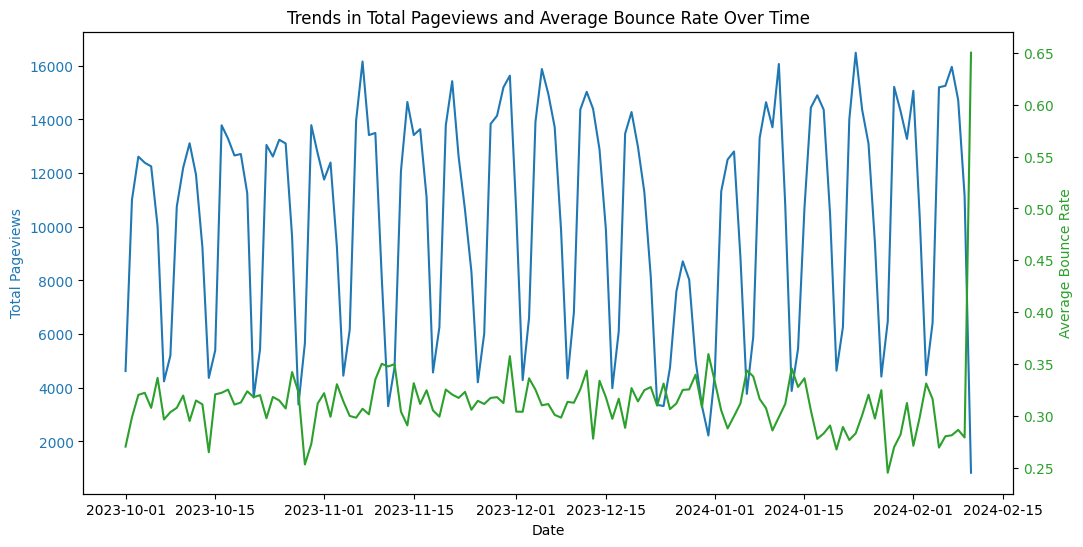

In [ ]:
# Aggregate data by date
trends = pages_df.groupby('date').agg(total_pageviews=('screenpageviews', 'sum'),
                                      average_bounce_rate=('bouncerate', 'mean'))

# Plotting the trends
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Date')
ax1.set_ylabel('Total Pageviews', color='tab:blue')
ax1.plot(trends.index, trends['total_pageviews'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Average Bounce Rate', color='tab:green')
ax2.plot(trends.index, trends['average_bounce_rate'], color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

plt.title('Trends in Total Pageviews and Average Bounce Rate Over Time')
plt.show()

#### Segmentation of Data by Date or Page Type

Compare metrics on weekdays versus weekends or across different types of pages.


<ipython-input-29-e8771278519c>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_type', y='average_pageviews', data=day_type_agg, palette='coolwarm')


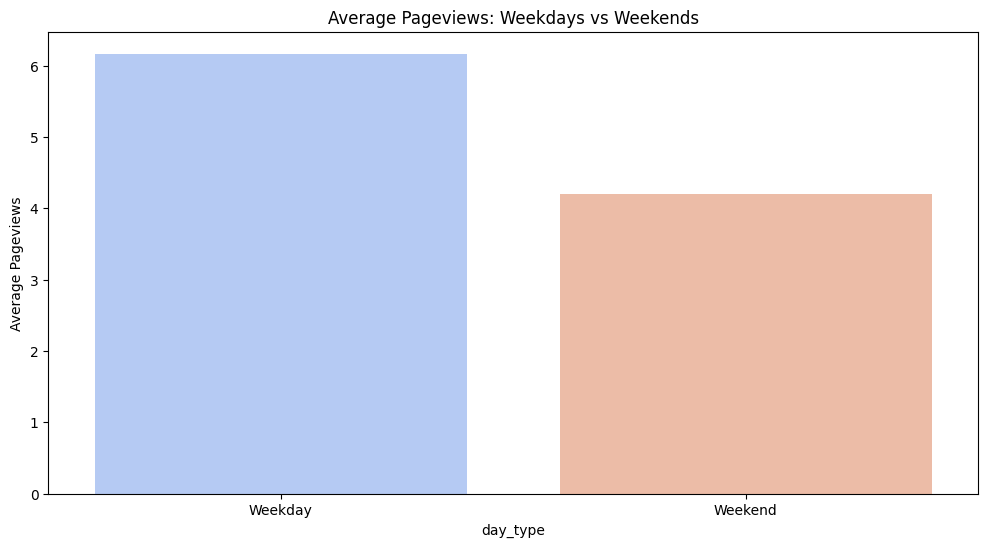

<ipython-input-29-e8771278519c>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_type', y='average_bounce_rate', data=day_type_agg, palette='viridis')


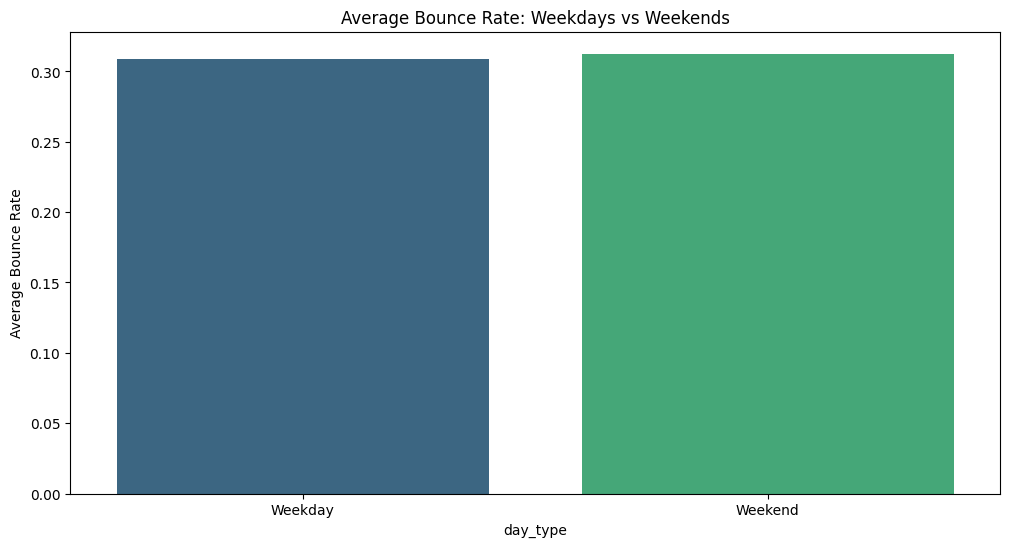

In [ ]:
import seaborn as sns

# Label rows as 'Weekday' or 'Weekend'
pages_df['day_type'] = pages_df['day_of_week'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

# Aggregating data for weekday vs weekend
day_type_agg = pages_df.groupby('day_type').agg(average_pageviews=('screenpageviews', 'mean'),
                                                average_bounce_rate=('bouncerate', 'mean')).reset_index()

# Plotting Average Pageviews
plt.figure(figsize=(12, 6))
sns.barplot(x='day_type', y='average_pageviews', data=day_type_agg, palette='coolwarm')
plt.title('Average Pageviews: Weekdays vs Weekends')
plt.ylabel('Average Pageviews')
plt.show()

# Plotting Average Bounce Rate
plt.figure(figsize=(12, 6))
sns.barplot(x='day_type', y='average_bounce_rate', data=day_type_agg, palette='viridis')
plt.title('Average Bounce Rate: Weekdays vs Weekends')
plt.ylabel('Average Bounce Rate')
plt.show()